In [1]:
# Import Packages 
import numpy as np 
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import tweepy
import webbrowser
import time
from datetime import datetime
from scipy import stats
from collections import Counter

# Suppress warning
from urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(category=InsecureRequestWarning)

# Text analysis
import nltk # NLTK: A basic, popular NLP package. 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Plots
import matplotlib.pyplot as plt

# Length of Pandas
pd.set_option('display.max_rows', 20)

from sentida import Sentida

In [2]:
# We will collect our saved data
df_Name_id_list = pd.read_csv('Name_id_Final.csv')
df_twitter_data = pd.read_csv('Twitter_data_Final.csv')

pd.set_option('display.max_rows', 20)

In [3]:
# Mergeing the two dataframes 

# Dropping people with out tweets
df_Name_id_list.sort_values('Tweet Count')
a = df_Name_id_list[df_Name_id_list['Tweet Count'] == 0]['Name'].to_list()
print('People with no Tweets: ' + str(a))
df_Name_id_list = df_Name_id_list[~df_Name_id_list['Name'].isin(a)]

# Dropping duplicates
dup = df_Name_id_list[df_Name_id_list.duplicated('Name')]['Name'].to_list()
print('People who enters more than once: ' + str(dup))
df_Name_id_list = df_Name_id_list.drop_duplicates('Name',keep='first')

# Merge certain columns
Col_Name = ['Name','Party','MP','Color','Twitter_id','Følgere','Tweet Count','y']
Col_Tweet = ['Date','Name','Tweet','Language','Likes','Retweets','Source']

# Merge
df_main_preprocessed = pd.merge(df_twitter_data[Col_Tweet],df_Name_id_list[Col_Name],how='left',on='Name')

# Remove english tweets
a = len(df_main_preprocessed)
df_main_preprocessed = df_main_preprocessed[df_main_preprocessed['Language'] != 'en'].reset_index(drop=True)
print('English tweets removed: ' + str(a-len(df_main_preprocessed)))

# Print df
df_main_preprocessed

People with no Tweets: ['Nick Hækkerup', 'Jan Johansen', 'Bjarne Laustsen']
People who enters more than once: ['Søren Egge Rasmussen']
English tweets removed: 3309


,Date,Name,Tweet,Language,Likes,Retweets,Source,Party,MP,Color,Twitter_id,Følgere,Tweet Count,y
0,2021-06-23 14:20:48,Ida Auken,"Jeg har grinet af denne her i flere dage, så n...",da,121,7,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
1,2021-06-12 17:31:49,Ida Auken,UEFA meddeler at Eriksen er stabiliseret. Hurr...,no,72,3,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
2,2021-06-12 17:26:59,Ida Auken,Sandt! #EM2020 https://t.co/QRLe1LRBsf,da,136,13,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
3,2021-06-09 08:36:50,Ida Auken,Svært ikke at være åbenhjertig ovor for så skø...,da,26,4,Twitter Web App,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
4,2021-06-06 12:18:23,Ida Auken,Tillykke 🇩🇰🇩🇰 https://t.co/Fj2WpbxITG,da,7,1,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100849,2017-05-08 05:03:36,Orla Østerby,En skræmmende undersøgelse - det her fortjener...,da,0,0,Hootsuite,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1
100850,2017-05-04 08:17:37,Orla Østerby,Morgensang i Samtaleværelset. Netop i dag den ...,da,6,0,Twitter for iPhone,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1
100851,2017-05-02 15:36:22,Orla Østerby,Godt nyt. Skattesatsen sænkes fra 1 procent ti...,da,2,0,Hootsuite,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1
100852,2017-04-26 05:58:20,Orla Østerby,"Dagtilbudslederen skal overveje, hvordan man k...",da,2,0,Hootsuite,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1


In [355]:
# Function to process the individual tweet
def preprocess(text):
    
    text = re.sub('http\S*','', text) # remove links

    if len(text) in [0,1,2,3,4,5,6] : return ['None']*3

    SV = Sentida()
    sentiment_mean_score = SV.sentida(text, output='mean', normal=True)

    text = re.sub(r'[^\w\#\s]','', text) 
    text = re.sub('\s[0-9]','', text) 

    tokens = nltk.TweetTokenizer().tokenize(text.lower()) # Keeps hashtag

    stop_words_list = nltk.corpus.stopwords.words("danish")
    lemmas = [i for i in tokens if i not in stop_words_list]

    text_new = ' '.join(lemmas)

    return lemmas, text_new, np.round(sentiment_mean_score,2)

# Function that will process every tweet
def process_tweets_data(df):
    
    info_list = []

    for i in range(len(df)):
        text = df['Tweet'][i]
        # print(i)
        stems, final_text, sentiment_mean = preprocess(text)
        
        # Gather infomation to df
        Date = df['Date'][i]
        Name = df['Name'][i]
        Language = df['Language'][i]
        Likes = df['Likes'][i]
        Retweets = df['Retweets'][i]
        Følgere = df['Følgere'][i]
        Tweet_count = df['Tweet Count'][i]
        y = df['y'][i]
        Party = df['Party'][i]

        # Append list
        info_list.append([Date, Name, Party ,Følgere,Tweet_count,text,Language,Likes,Retweets,stems,final_text,sentiment_mean,y])
    
    # Create columns names
    Col_name = ['Date','Name','Party','Følgere','Tweet Count','Tweet','la','Likes','Retweets','Stems','Final Text','Sentiment','y']

    # Create new dataframe
    df_out = pd.DataFrame(info_list, columns=Col_name)
    return df_out


In [359]:
# Example of the text process
text= df_main_preprocessed['Tweet'][4]

results = preprocess(text)
 
# Text
print('Old text: \n' + text  + '\n')
print('New text (text): ' + str(len(results[1])) + ' list length \n' + str(results[1]) + '\n')
print('New text (Stems): ' + str(len(results[0])) + ' list length \n' + str(results[0]) + '\n')

# Sentiment scores
print('The mean sentiment score is: ' + str(results[2]))


Old text: 
Tillykke 🇩🇰🇩🇰 https://t.co/Fj2WpbxITG

New text (text): 8 list length 
tillykke

New text (Stems): 1 list length 
['tillykke']

The mean sentiment score is: 0.8


In [356]:
# Create a main dataframe (approx = 6-700 sec.)
df_main_backup = process_tweets_data(df_main_preprocessed)
df_main = df_main_backup.copy()
df_main

,Date,Name,Party,Følgere,Tweet Count,Tweet,la,Likes,Retweets,Stems,Final Text,Sentiment,y
0,2021-06-23 14:20:48,Ida Auken,Socialdemokratiet (S),73.926,879,"Jeg har grinet af denne her i flere dage, så n...",da,121,7,"[grinet, flere, dage, så, får, passer, desværr...",grinet flere dage så får passer desværre midt ...,0.14,0
1,2021-06-12 17:31:49,Ida Auken,Socialdemokratiet (S),73.926,879,UEFA meddeler at Eriksen er stabiliseret. Hurr...,no,72,3,"[uefa, meddeler, eriksen, stabiliseret, hurra,...",uefa meddeler eriksen stabiliseret hurra #em2021,0.7,0
2,2021-06-12 17:26:59,Ida Auken,Socialdemokratiet (S),73.926,879,Sandt! #EM2020 https://t.co/QRLe1LRBsf,da,136,13,"[sandt, #em2020]",sandt #em2020,0.35,0
3,2021-06-09 08:36:50,Ida Auken,Socialdemokratiet (S),73.926,879,Svært ikke at være åbenhjertig ovor for så skø...,da,26,4,"[svært, åbenhjertig, ovor, så, skøn, samtalepa...",svært åbenhjertig ovor så skøn samtalepartner ...,-0.03,0
4,2021-06-06 12:18:23,Ida Auken,Socialdemokratiet (S),73.926,879,Tillykke 🇩🇰🇩🇰 https://t.co/Fj2WpbxITG,da,7,1,[tillykke],tillykke,0.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100849,2017-05-08 05:03:36,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,En skræmmende undersøgelse - det her fortjener...,da,0,0,"[skræmmende, undersøgelse, fortjener, ingen, b...",skræmmende undersøgelse fortjener ingen børn #...,-0.4,1
100850,2017-05-04 08:17:37,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,Morgensang i Samtaleværelset. Netop i dag den ...,da,6,0,"[morgensang, samtaleværelset, netop, dag, 4, m...",morgensang samtaleværelset netop dag 4 maj san...,0.02,1
100851,2017-05-02 15:36:22,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,Godt nyt. Skattesatsen sænkes fra 1 procent ti...,da,2,0,"[godt, nyt, skattesatsen, sænkes, procent, 55,...",godt nyt skattesatsen sænkes procent 55 procen...,0.18,1
100852,2017-04-26 05:58:20,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,"Dagtilbudslederen skal overveje, hvordan man k...",da,2,0,"[dagtilbudslederen, overveje, hvordan, kan, in...",dagtilbudslederen overveje hvordan kan inddrag...,0.03,1


In [427]:
# Delete rows with no final text (pictures and emoji)
df_main_done = df_main[df_main['Stems']!='None'].reset_index(drop=True)

# Setting dates to after 2015-01-01
df_main_done['Date'] = pd.to_datetime(df_main_done['Date'],format = '%Y-%m-%d %H:%M:%S')
df_main_done = df_main_done.loc[df_main_done['Date'] >= '2015-1-01'].reset_index(drop=True)


Text(0.5, 1.0, '1. January 2015 - 18. June 2015')

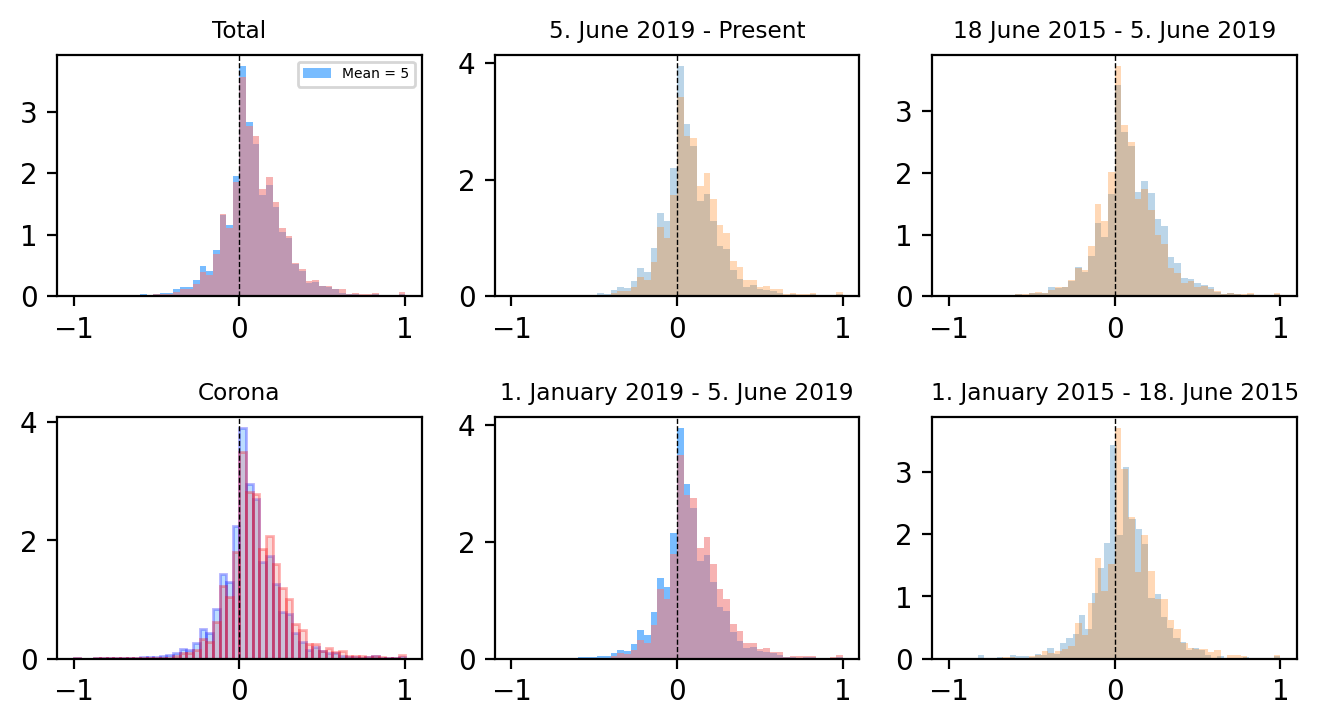

In [428]:
# Create dataframes (Election-periods, the 6-month preelection, corona period)
# Total 
df_blue = df_main_done[df_main_done['y']==1]
df_red  = df_main_done[df_main_done['y']==0]

xb = np.array(df_blue['Sentiment'].to_list())
xr = np.array(df_red['Sentiment'].to_list())

# 2015 election period
df_2017_valg = df_main_done.loc[df_main_done['Date'] >= '2015-06-18'].reset_index(drop=True)
df_2017_valg = df_2017_valg.loc[df_2017_valg['Date'] <= '2019-06-05'].reset_index(drop=True)

df_blue_2017 = df_2017_valg[df_2017_valg['y']==1]
df_red_2017  = df_2017_valg[df_2017_valg['y']==0]

xb_2017 = np.array(df_blue_2017['Sentiment'].to_list())
xr_2017 = np.array(df_red_2017['Sentiment'].to_list())


# 2019 election period
df_2019_valg = df_main_done.loc[df_main_done['Date'] >= '2019-06-05'].reset_index(drop=True)

df_blue_2019 = df_2019_valg[df_2019_valg['y']==1]
df_red_2019  = df_2019_valg[df_2019_valg['y']==0]

xb_2019 = np.array(df_blue_2019['Sentiment'].to_list())
xr_2019 = np.array(df_red_2019['Sentiment'].to_list())

# 2015 election pre period
df_2017_valg_pre = df_main_done.loc[df_main_done['Date'] <= '2015-06-18'].reset_index(drop=True)
df_2017_valg_pre = df_2017_valg_pre.loc[df_2017_valg_pre['Date'] >= '2015-01-01'].reset_index(drop=True)

df_blue_2017_pre = df_2017_valg_pre[df_2017_valg_pre['y']==1]
df_red_2017_pre  = df_2017_valg_pre[df_2017_valg_pre['y']==0]

xb_2017_pre = np.array(df_blue_2017_pre['Sentiment'].to_list())
xr_2017_pre = np.array(df_red_2017_pre['Sentiment'].to_list())

# 2019 election pre period
df_2019_valg_pre = df_main_done.loc[df_main_done['Date'] <= '2019-06-05'].reset_index(drop=True)
df_2019_valg_pre = df_main_done.loc[df_main_done['Date'] >= '2019-01-01'].reset_index(drop=True)

df_blue_2019_pre = df_2019_valg_pre[df_2019_valg_pre['y']==1]
df_red_2019_pre  = df_2019_valg_pre[df_2019_valg_pre['y']==0]

xb_2019_pre = np.array(df_blue_2019_pre['Sentiment'].to_list())
xr_2019_pre = np.array(df_red_2019_pre['Sentiment'].to_list())

# corona period
df_corona = df_main_done.loc[df_main_done['Date'] >= '2020-03-11'].reset_index(drop=True)

df_blue_corona = df_corona[df_corona['y']==1]
df_red_corona  = df_corona[df_corona['y']==0]

xb_corona = np.array(df_blue_corona['Sentiment'].to_list())
xr_corona = np.array(df_red_corona['Sentiment'].to_list())


# Create Plots 

fig = plt.figure(figsize=(8, 4), dpi=200)
fig.subplots_adjust(hspace = 0.5)

kwargs_blue = {'histtype': 'stepfilled', 'bins': 50, 'alpha' :  0.6, 'density' : True ,'color' : 'dodgerblue'}
kwargs_red = {'histtype': 'stepfilled', 'bins': 50, 'alpha' :  0.6, 'density' : True ,'color' : 'lightcoral'}

ax_Total = fig.add_subplot(2,3,1)
ax_Total.hist(xb,label='Mean = ' + str(5), **kwargs_blue)
ax_Total.hist(xr, **kwargs_red)
ax_Total.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_Total.set_title('Total',size = 'small')
ax_Total.legend(fontsize=5)

ax_2019 = fig.add_subplot(2,3,2)
ax_2019.hist(xb_2019,bins=50, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_2019.hist(xr_2019,bins=50, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_2019.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_2019.set_title('5. June 2019 - Present',size='small')

ax_2017 = fig.add_subplot(2,3,3)
ax_2017.hist(xb_2017,bins=50, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_2017.hist(xr_2017,bins=50, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_2017.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_2017.set_title('18 June 2015 - 5. June 2019',size='small')

ax_Corona = fig.add_subplot(2,3,4)
ax_Corona.hist(xb_corona,bins=50,ec='blue',alpha= 0.3,color='dodgerblue',density=True,histtype='bar')
ax_Corona.hist(xr_corona,bins=50,ec='red',alpha= 0.3,color='lightcoral',density=True,histtype='bar')
ax_Corona.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_Corona.set_title('Corona',size = 'small')

ax_2019_pre = fig.add_subplot(2,3,5)
ax_2019_pre.hist(xb_2019_pre,bins=50, histtype= 'stepfilled',alpha= 0.6,density=True,color='dodgerblue')
ax_2019_pre.hist(xr_2019_pre,bins=50, histtype= 'stepfilled',alpha= 0.6,density=True,color='lightcoral')
ax_2019_pre.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_2019_pre.set_title('1. January 2019 - 5. June 2019',size='small')

ax_2017_pre = fig.add_subplot(2,3,6)
ax_2017_pre.hist(xb_2017_pre,bins=50, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_2017_pre.hist(xr_2017_pre,bins=50, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_2017_pre.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_2017_pre.set_title('1. January 2015 - 18. June 2015',size='small')

In [431]:
# Create a 6 month running average sentiment score across the blocks
def six_month_average(df):
    df_blue = df[df['y']==1]
    df_red = df[df['y']==0]
    blue_sentiment_average_month = []
    red_sentiment_average_month = []
    dates = []
    

    date_list = df['Date'].sort_values().reset_index(drop=True).to_list()
    year, month = date_list[0].year, date_list[0].month
    end_year, end_month = date_list[-1].year, date_list[-1].month

    while (year < end_year) or (month < end_month):
        if month > 12: # execute next year
            year = year + 1 # Dont touch
            month = 1 # Dont touch
        else:
            date = str(year) + '-' + str(month) + '-01'
            if month == 12:
                date_next = str(year+1) + '-1-01'
            else:
                date_next = str(year) + '-' + str(month+1) + '-01'

            dates.append(date)
            
            df_blue_month = df_blue.loc[df_blue['Date'] >= date].reset_index(drop=True)
            df_blue_month = df_blue_month.loc[df_blue_month['Date'] < date_next].reset_index(drop=True)
            df_red_month = df_red.loc[df_red['Date'] >= date].reset_index(drop=True)
            df_red_month = df_red_month.loc[df_red_month['Date'] < date_next].reset_index(drop=True)

            blue_sentiment_average_month.append(df_blue_month['Sentiment'].mean())
            red_sentiment_average_month.append(df_red_month['Sentiment'].mean())

            
            month = month +1 # Dont touch

    blue_moving_average = np.convolve(np.array(blue_sentiment_average_month), np.ones(7), 'valid')/7
    red_moving_average = np.convolve(np.array(red_sentiment_average_month), np.ones(7), 'valid')/7
         

    return blue_moving_average, red_moving_average, blue_sentiment_average_month, red_sentiment_average_month, dates



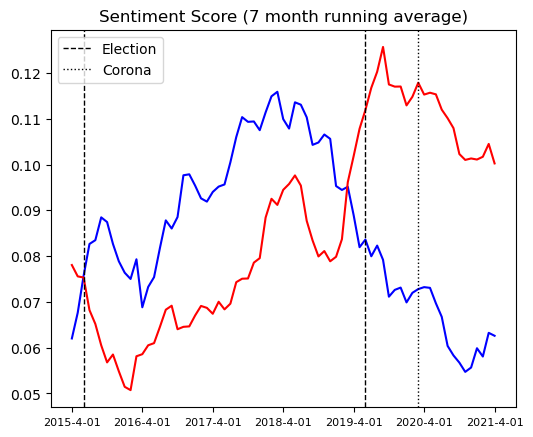

In [433]:
a = six_month_average(df_main_done)
dates = a[4][3:-3]


fig1 = plt.figure(figsize=(6, 5), dpi=100)


x_blue = np.array(np.arange(len(a[0])))
y_blue = np.array(a[0])
x_red = np.array(np.arange(len(a[1])))
y_red = np.array(a[1])

plt.xticks(x_blue[::12], dates[::12],fontsize=8)

plt.plot(x_blue, y_blue,color='blue')
plt.plot(x_red, y_red,color='red')
plt.title('Sentiment Score (7 month running average)')
plt.axvline(2,linestyle = '--', linewidth = 1, color='black')
plt.axvline(50,linestyle = '--', linewidth = 1, color='black',label='Election')
plt.axvline(59,linestyle = ':', linewidth = 1, color='black',label='Corona')
plt.legend(loc='upper left')
plt.show()



In [430]:
def get_description(array):
    info = []
    obs = stats.describe(array).nobs
    mean = stats.describe(array).mean
    min = stats.describe(array).minmax[0]
    max = stats.describe(array).minmax[1]
    var = stats.describe(array).variance
    skewness = stats.describe(array).skewness
    kurtosis = stats.describe(array).kurtosis

    info.append([obs,mean,var,min,max,skewness,kurtosis])
    return info[0]


db_total, dr_total = get_description(xb), get_description(xr)
db_2019, dr_2019 = get_description(xb_2019), get_description(xr_2019)
db_2017, dr_2017 = get_description(xb_2017), get_description(xr_2017)
db_corona, dr_corona = get_description(xb_corona), get_description(xr_corona)
db_2019_pre, dr_2019_pre = get_description(xb_2019_pre), get_description(xr_2019_pre)
db_2017_pre, dr_2017_pre = get_description(xb_2017_pre), get_description(xr_2017_pre)

time = np.array(['Blå (Total)','Rød (Total)','Blå (corona)','Rød (corona)','Blå (2019-nu)','Rød (2019-nu)','Blå (2019 pre election)','Rød (2019 pre election)','Blå (2015-2019)','Rød (2015-2019)','Blå (2015 pre election)','Rød (2015 pre election)'])
df_info_sentiment = pd.DataFrame([db_total,dr_total,db_corona,dr_corona,db_2019,dr_2019,db_2019_pre, dr_2019_pre, db_2017,dr_2017,db_2017_pre,dr_2017_pre],columns=(['obs','mean','variance','min','max','skeness','kurtosis'])).set_index(time,drop=True)
df_info_sentiment
# print(stats.describe(xb))
# print(stats.describe(xr_array))


,obs,mean,variance,min,max,skeness,kurtosis
Blå (Total),37654,0.078556,0.035696,-1.0,1.0,0.181180,2.928171
Rød (Total),52273,0.094952,0.036728,-1.0,1.0,0.497881,3.246592
Blå (corona),13598,0.063244,0.032384,-1.0,1.0,0.225611,3.561451
Rød (corona),19515,0.106660,0.033272,-1.0,1.0,0.721114,3.188723
Blå (2019-nu),18402,0.066456,0.032718,-1.0,1.0,0.227143,3.583758
Rød (2019-nu),27245,0.111270,0.034606,-1.0,1.0,0.674169,3.162027
Blå (2019 pre election),21845,0.069808,0.032490,-1.0,1.0,0.254652,3.475006
Rød (2019 pre election),31906,0.107929,0.033848,-1.0,1.0,0.677171,3.277902
Blå (2015-2019),16115,0.097252,0.038532,-1.0,1.0,0.174865,2.343428
Rød (2015-2019),22997,0.076897,0.038466,-1.0,1.0,0.380317,3.362082


In [372]:
def find_hashtags(df):
    """
    Function that finds every hashtag in the column 'Tweet' and count the appearances
    """
    counter_hashtag = Counter()

    for i in range(len(df)):
        text = df['Tweet'][i]
        find_h = re.findall('\#\S*',text)
        new = Counter(find_h)
        counter_hashtag = counter_hashtag + new
    
    df_out = pd.DataFrame(dict(counter_hashtag).items(), columns=['Word','Count'])
    return df_out

In [376]:
text = df_main_done.copy()

text = text.loc[text['Date'] >= '2019-06-05'].reset_index(drop=True)

# text = text.loc[text['Date'] >= '2020-03-11'].reset_index(drop=True)
# text = text.loc[text['Date'] <= '2020-12-31'].reset_index(drop=True)

df_hashtags_2019 = find_hashtags(text)

df_hashtags_2019 = df_hashtags_2019.sort_values('Count',ascending=False).reset_index(drop=True)
df_hashtags_2019[0:20]

,Word,Count
0,#dkpol,31467
1,#dkgreen,2956
2,#dkmedier,1551
3,#sundpol,938
4,#dktrp,843
5,#ftlive,691
6,#COVID19dk,559
7,#dkbiz,417
8,#dksocial,364
9,#uddpol,320


In [539]:
len(df_hashtags_2019)

4731

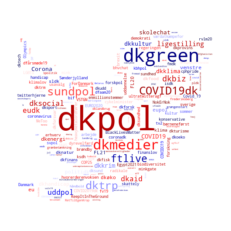

In [552]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from IPython.display import Image as im

df_word_cloud = df_hashtags_2019.copy()

number_of_words = 997

text_word = df_word_cloud['Word'][0:number_of_words].to_list()
text_count = df_word_cloud['Count'][0:number_of_words].to_list()

text_wc = sum([[s] * n for s,n, in zip(text_word,text_count)], [])

text_wc = ' '.join(text_wc)


# mask = np.array(Image.open('Twitterlogo.png'))
size = (500,500)
mask = np.array(Image.open('Twitterlogo1.png').convert('L').resize(size))

colors_wc = ()

# word_cloud = WordCloud(collocations = False,colormap='RdBu',  background_color = 'white',mask=mask,width=400,height=400).generate(text_wc) #width=1000,height=1000
# word_cloud = WordCloud(collocations = False,colormap='plasma',  background_color = 'white',mask=mask,width=400,height=400).generate(text_wc) #width=1000,height=1000
# word_cloud = WordCloud(collocations = False,colormap='prism',  background_color = 'white',mask=mask,width=400,height=400).generate(text_wc) #width=1000,height=1000
word_cloud = WordCloud(collocations = False,colormap='seismic',  background_color = 'white',mask=mask,width=400,height=400).generate(text_wc) #width=1000,height=1000
# word_cloud = WordCloud(collocations = False,colormap='tab10',  background_color = 'white',mask=mask,width=400,height=400).generate(text_wc) #width=1000,height=1000
# word_cloud = WordCloud(collocations = False,colormap='twilight',  background_color = 'white',mask=mask,width=400,height=400).generate(text_wc) #width=1000,height=1000
# word_cloud = WordCloud(collocations = False,colormap='turbo',  background_color = 'white',mask=mask,width=400,height=400).generate(text_wc) #width=1000,height=1000
# word_cloud = WordCloud(collocations = False,colormap=colors_wc,  background_color = 'white',mask=mask,width=400,height=400).generate(text_wc) #width=1000,height=1000


# plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
word_cloud.to_file('WordCloud.png')




In [377]:
# Create a new test dataframe for ML 
test = df_main_done.copy()

list_of_words= df_hashtags_2019['Word'][0:20].to_list()

pattern = '|'.join(list_of_words)

df_test = test[test['Final Text'].str.contains(pattern)]
df_test = df_test.loc[df_test['Date'] >= '2019-06-05'].reset_index(drop=True)

df_test

,Date,Name,Party,Følgere,Tweet Count,Tweet,la,Likes,Retweets,Stems,Final Text,Sentiment,y
0,2021-06-09 08:36:50,Ida Auken,Socialdemokratiet (S),73.926,879,Svært ikke at være åbenhjertig ovor for så skø...,da,26,4,"[svært, åbenhjertig, ovor, så, skøn, samtalepa...",svært åbenhjertig ovor så skøn samtalepartner ...,-0.03,0
1,2021-06-03 08:24:02,Ida Auken,Socialdemokratiet (S),73.926,879,"Har skrevet lidt om et område, der virkelig ha...",da,20,2,"[skrevet, lidt, område, virkelig, halter, bagu...",skrevet lidt område virkelig halter bagud fht ...,-0.01,0
2,2021-06-02 07:38:40,Ida Auken,Socialdemokratiet (S),73.926,879,"På lidt over et år har vi taget beslutninger, ...",da,59,6,"[lidt, år, taget, beslutninger, bringer, halvd...",lidt år taget beslutninger bringer halvdelen v...,0.12,0
3,2021-05-26 09:54:50,Ida Auken,Socialdemokratiet (S),73.926,879,Har du endnu ikke set dokumentaren 70/30 om kl...,da,17,4,"[endnu, set, dokumentaren, 7030, klimalovens, ...",endnu set dokumentaren 7030 klimalovens tilbli...,0.02,0
4,2021-05-24 19:34:25,Ida Auken,Socialdemokratiet (S),73.926,879,Ren luft i byen og et vigtigt skub til elbiler...,da,36,5,"[ren, luft, byen, vigtigt, skub, elbilerne, gl...",ren luft byen vigtigt skub elbilerne glæder ud...,0.21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32808,2020-01-06 21:19:13,Susanne Zimmer,Uden for folketingsgrupperne (UFG),1.570,1102,Det er et dårligt tegn at op mod hver 5. kvind...,da,53,9,"[dårligt, tegn, hver, 5, kvinde, fødedygtige, ...",dårligt tegn hver 5 kvinde fødedygtige alder p...,0.02,0
32809,2020-01-06 18:19:08,Susanne Zimmer,Uden for folketingsgrupperne (UFG),1.570,1102,Alternativet ønsker Naturstyrelsen på finanslo...,da,20,1,"[alternativet, ønsker, naturstyrelsen, finansl...",alternativet ønsker naturstyrelsen finansloven...,0.11,0
32810,2020-01-06 08:34:57,Susanne Zimmer,Uden for folketingsgrupperne (UFG),1.570,1102,Nu har vi lavet et flot Handleplan mod børn og...,da,29,10,"[lavet, flot, handleplan, børn, unges, rygning...",lavet flot handleplan børn unges rygning så ti...,0.1,0
32811,2020-01-03 22:57:12,Susanne Zimmer,Uden for folketingsgrupperne (UFG),1.570,1102,Hvor er det et fint udspil RV kommer med. I Al...,da,54,5,"[fint, udspil, rv, kommer, alternativet, længe...",fint udspil rv kommer alternativet længe slået...,-0.06,0


In [378]:
# LONG TWEETS
X, y = df_test['Final Text'], df_test['y']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

vect = CountVectorizer(ngram_range=(1,4), max_features = 200)

X_train = vect.fit_transform(X_train)
X_test = vect.fit_transform(X_test)
print("We have " + str(np.round(sum(y_train)/len(y_train)*100,2)) + '% of blue tweets in our train')
print("We have " + str(np.round(sum(y_test)/len(y_test)*100,2)) + '% of blue tweets in our test')

We have 38.51% of blue tweets in our train
We have 38.0% of blue tweets in our test


In [ ]:
# LONG TWEETS
X, y = df_main_done['Final Text'], df_main_done['y']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

vect = CountVectorizer(ngram_range=(1,4), max_features = 200)

X_train = vect.fit_transform(X_train)
X_test = vect.fit_transform(X_test)
print("We have " + str(np.round(sum(y_train)/len(y_train)*100,2)) + '% of blue tweets in our train')
print("We have " + str(np.round(sum(y_test)/len(y_test)*100,2)) + '% of blue tweets in our test')

We have 40.36% of blue tweets in our train
We have 40.18% of blue tweets in our test


In [386]:
model = LogisticRegression(max_iter = 1000, solver = 'saga', penalty ='l1', fit_intercept=True ).fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred = y_pred



In [ ]:
# Process tweets
df_tweet_processed = process_tweets_text(df_twitter_data)

# Create a main dataframe with all information
Col = ['Name','Party','MP','Color','Twitter_id','Følgere','Tweet Count','y']
df_main = pd.merge(df_Name_id[Col],df_tweet_processed,how='left',on='Name')
df_main.head(5)

In [ ]:
df_test = df_main.copy()
df_test = df_test[df_test['Language'] != 'en'].reset_index(drop=True)

df_test['Date'] = pd.to_datetime(df_test['Date'],format = '%Y-%m-%d %H:%M:%S')
df_test = df_test.loc[df_test['Date'] >= '2017-01-01'].reset_index(drop=True)

df_test = df_test.loc[df_test['Tweet Processed'].str.len() >= 2].reset_index(drop=True)

print('We have ' + str(np.round(sum(df_test['y'])/len(df_test),3)*100) + '% red in our dataframe')
df_test

In [387]:
print('Our testset is: ' + str(len(y_test)) + ' observation \nTrue: ' + str(y_test.sum()) + ' Blue tweets' )
a = y_pred == y_test
print('We found: ' + str(y_pred.sum()) + ' Blue tweets \nWe predicted: ' + str(np.round(a.mean()*100,2)) + ' % correct tweets overall')
a = Counter(y_pred-y_test)

print('\nWe missed to predict: ' + str(a[-1]) + ' Tweets \n\nOf the predicted Blue (' + str(y_pred.sum()) + ') \nCorrect prediction: ' + str(y_pred.sum()-a[1]) + '\nWrong prediction: ' + str(a[1]))

print('\nOf the predicted Red (' + str(len(y_pred) - y_pred.sum()) + ') \nCorrect prediction: ' + str(len(y_pred) - y_pred.sum()-a[-1]) + '\nWrong prediction: ' + str(a[-1]))



Our testset is: 9844 observation 
True: 3741 Blue tweets
We found: 0 Blue tweets 
We predicted: 62.0 % correct tweets overall

We missed to predict: 3741 Tweets 

Of the predicted Blue (0) 
Correct prediction: 0
Wrong prediction: 0

Of the predicted Red (9844) 
Correct prediction: 6103
Wrong prediction: 3741


In [388]:
words = vect.get_feature_names()
count = X_train.toarray().sum(axis=0).tolist()

df_word_count = pd.DataFrame([words,count]).T
df_word_count.sort_values(1,ascending=False)

# ['#dkpol','#dkgreen','#dkmedier','sundpol','dkpol','dkmedier','regering','mink','covid19dk','regeringdk','politik','enhedslisten','venstredk','spolitik','venstre','radikale','dktrp']


,0,1
33,dkpol,22127
172,tage,4576
93,klima,3986
70,gode,2277
31,dkgreen,2049
...,...,...
128,ny,275
78,hele,272
103,landet,272
101,kæmpe,265


In [314]:
# Find Party prediction 
def party_pred(df,party):
    
    # reset y and set party = 1 
    df['y'] = 0
    df['y'][df['Party']==party] = 1 

    # Prediction
    X, y = df['Final Text'], df['y']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)
    vect = CountVectorizer(ngram_range=(1,4), max_features = 200)
    X_train = vect.fit_transform(X_train)
    X_test = vect.fit_transform(X_test)
    model = LogisticRegression(max_iter = 1000, solver = 'saga', penalty ='l1', fit_intercept=True ).fit(X_train,y_train)
    y_pred = model.predict(X_test)

    # Result prints
    # if print == True:
    print('Party: ' + party + '\n')
    print("We have " + str(np.round(sum(y_train)/len(y_train)*100,2)) + '% of target tweets in our train')
    print("We have " + str(np.round(sum(y_test)/len(y_test)*100,2)) + '% of taget tweets in our test\n')

    print('Our testset is: ' + str(len(y_test)) + ' observation \nTrue: ' + str(y_test.sum()) + ' Taget tweets' )
    a = y_pred == y_test
    print('We found: ' + str(y_pred.sum()) + ' taget tweets \nWe predicted: ' + str(np.round(a.mean()*100,2)) + ' % correct tweets overall')
    print('Guessing all 0 prediction: ' + str(np.round(100 - sum(y_test)/len(y_test)*100,2)) + ' %')
    a = Counter(y_pred-y_test)
    print('\nWe missed to predict: ' + str(a[-1]) + ' Tweets \n\nOf the predicted (' + str(y_pred.sum()) + ') \nCorrect prediction: ' + str(y_pred.sum()-a[1]) + '\nWrong prediction: ' + str(a[1]))

    return y_train, y_test, y_pred
    


In [283]:
df_main_done['Party'].unique()

array(['Socialdemokratiet (S)', 'Venstre (V)', 'Dansk Folkeparti (DF)',
       'Socialistisk Folkeparti (SF)', 'Radikale Venstre (RV)',
       'Enhedslisten (EL)', 'Det Konservative Folkeparti (KF)',
       'Nye Borgerlige (NB)', 'Liberal Alliance (LA)',
       'Alternativet (ALT)', 'Kristendemokraterne (KD)',
       'Uden for folketingsgrupperne (UFG)'], dtype=object)

In [300]:
party_pred(df_test,'Socialdemokratiet (S)')

<ipython-input-299-a282e176eeaf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'][df['Party']==party] = 1


Party: Socialdemokratiet (S)

We have 23.0% of target tweets in our train
We have 24.54% of taget tweets in our test

Our testset is: 9844 observation 
True: 2416 Taget tweets
We found: 625 taget tweets 
We predicted: 76.02 % correct tweets overall
Guessing all 0 prediction: 75.46 %

We missed to predict: 2076 Tweets 

Of the predicted (625) 
Correct prediction: 340
Wrong prediction: 285


In [315]:
party_pred(df_test,'Enhedslisten (EL)')

<ipython-input-314-febbe9a38026>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'][df['Party']==party] = 1


Party: Enhedslisten (EL)

We have 9.53% of target tweets in our train
We have 9.27% of taget tweets in our test

Our testset is: 9844 observation 
True: 913 Taget tweets
We found: 270 taget tweets 
We predicted: 91.92 % correct tweets overall
Guessing all 0 prediction: 90.73 %

We missed to predict: 719 Tweets 

Of the predicted (270) 
Correct prediction: 194
Wrong prediction: 76


(26724    1
 30192    0
 23045    0
 19356    0
 63       0
         ..
 21440    0
 7813     0
 32511    0
 5192     0
 12172    0
 Name: y, Length: 22969, dtype: int64,
 19803    0
 25421    1
 11218    0
 15111    0
 31915    0
         ..
 3577     0
 30935    0
 19966    0
 2364     0
 13610    0
 Name: y, Length: 9844, dtype: int64,
 array([0, 1, 0, ..., 0, 0, 0]))

In [310]:
party_list = df_main_done['Party'].unique()
party_list = party_list[0:2]
for i in range(len(party_list)):
    party = party_list[i]
    y_train, y_test, y_pred = party_pred(df_main_done, party)
    
    obs = len(y_test)
    found = sum(y_pred)
    true = sum(y_test)

    a = y_pred == y_test
    pred_ratio = np.round(a.mean()*100,2)
    pre_ratio_0 = np.round(100 - sum(y_test)/len(y_test)*100,2)

    a = Counter(y_pred-y_test)
    missed_predict = a[-1]
    
    print('\nWe missed to predict: ' + str(a[-1]) + ' Tweets \n\nOf the predicted (' + str(y_pred.sum()) + ') \nCorrect prediction: ' + str(y_pred.sum()-a[1]) + '\nWrong prediction: ' + str(a[1]))
    
    

    


'Venstre (V)'